In [66]:
from ratsnlp.nlpbook.classification import ClassificationTrainArguments 
args = ClassificationTrainArguments(
	pretrained_model_name="beomi/kcbert-base", 
	downstream_corpus_name="nsmc", 
	downstream_corpus_root_dir="/content/Korpora", 
	downstream_model_dir="/gdrive/My Drive/nlpbook/checkpoint-doccls", 
	learning_rate=5e-5,
	batch_size=32, 
)

말뭉치 다운로드 및 전처리
오픈소스 파이썬 패키지 코포라(Korpora)를 활용해 BPE 수행 대상 말뭉치를 내려받고 전처리합니다. 실습용 말뭉치는 박은정 님이 공개하신 Naver Sentiment Movie Corpus(NSMC)입니다.

다음을 수행해 데이터를 내려받아 nsmc라는 변수로 읽어들입니다.

In [67]:
from Korpora import Korpora
nsmc = Korpora.load("nsmc", force_download=True)


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/



[nsmc] download ratings_train.txt: 14.6MB [00:01, 11.4MB/s]                            
[nsmc] download ratings_test.txt: 4.90MB [00:00, 10.8MB/s]                            


In [108]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [69]:
import os
os.environ['JAVA_HOME'] = 'C:\\Program Files\\Java\\jdk-21'  # 여기에 자신의 JDK 설치 경로를 입력하세요


In [70]:
df = pd.read_csv("../T/gangnam_cafe_2.csv")


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    108 non-null    object
 1   review  108 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


In [72]:
df.head()


,name,review
0,한과와락,여기 개성주악 맛있어욤 벌써 2번째입니다\n강남에 이렇게 이쁜 카페 있는줄 몰랐다 ...
1,레뽀드라라 강남점,비엔나 커피 맛있어요\n유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이...
2,한과와락,여기 개성주악 맛있어욤 벌써 2번째입니다\n강남에 이렇게 이쁜 카페 있는줄 몰랐다 ...
3,레뽀드라라 강남점,비엔나 커피 맛있어요\n유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이...
4,스템커피 강남점,디저트 종류도 많고 카페도 깨끗해서 좋아요:)\n라떼 넘 맛있어엽! 전반적으로 달달...


In [73]:
# 결측치 제거 및 텍스트 정제

# 필요한 컬럼 선택
df = df[['review', 'name']]

# 결측치 제거
df = df.dropna()

# 문자열로 변환
df['review'] = df['review'].astype(str)

# 레이블 인코딩 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['name'] = le.fit_transform(df['name'])

# 불필요한 문자 제거
df['clean_review'] = df['review'].str.replace("[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [74]:
df.head()

,review,name,clean_review
0,여기 개성주악 맛있어욤 벌써 2번째입니다\n강남에 이렇게 이쁜 카페 있는줄 몰랐다 ...,94,여기 개성주악 맛있어욤 벌써 2번째입니다\n강남에 이렇게 이쁜 카페 있는줄 몰랐다 ...
1,비엔나 커피 맛있어요\n유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이...,15,비엔나 커피 맛있어요\n유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이...
2,여기 개성주악 맛있어욤 벌써 2번째입니다\n강남에 이렇게 이쁜 카페 있는줄 몰랐다 ...,94,여기 개성주악 맛있어욤 벌써 2번째입니다\n강남에 이렇게 이쁜 카페 있는줄 몰랐다 ...
3,비엔나 커피 맛있어요\n유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이...,15,비엔나 커피 맛있어요\n유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이...
4,디저트 종류도 많고 카페도 깨끗해서 좋아요:)\n라떼 넘 맛있어엽! 전반적으로 달달...,53,디저트 종류도 많고 카페도 깨끗해서 좋아요:)\n라떼 넘 맛있어엽! 전반적으로 달달...


In [75]:
# 토큰화
from konlpy.tag import Okt

okt = Okt()

df['tokenized_review'] = df['clean_review'].apply(okt.morphs)

print(df.head())


                                              review  name  \
0  여기 개성주악 맛있어욤 벌써 2번째입니다\n강남에 이렇게 이쁜 카페 있는줄 몰랐다 ...    94   
1  비엔나 커피 맛있어요\n유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이...    15   
2  여기 개성주악 맛있어욤 벌써 2번째입니다\n강남에 이렇게 이쁜 카페 있는줄 몰랐다 ...    94   
3  비엔나 커피 맛있어요\n유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이...    15   
4  디저트 종류도 많고 카페도 깨끗해서 좋아요:)\n라떼 넘 맛있어엽! 전반적으로 달달...    53   

                                        clean_review  \
0  여기 개성주악 맛있어욤 벌써 2번째입니다\n강남에 이렇게 이쁜 카페 있는줄 몰랐다 ...   
1  비엔나 커피 맛있어요\n유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이...   
2  여기 개성주악 맛있어욤 벌써 2번째입니다\n강남에 이렇게 이쁜 카페 있는줄 몰랐다 ...   
3  비엔나 커피 맛있어요\n유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이...   
4  디저트 종류도 많고 카페도 깨끗해서 좋아요:)\n라떼 넘 맛있어엽! 전반적으로 달달...   

                                    tokenized_review  
0  [여기, 개성, 주악, 맛있어, 욤, 벌써, 2, 번, 째, 입니다, \n, 강남,...  
1  [비엔나, 커피, 맛있어요, \n, 유명한, 스콘, 집, 이라고, 왔어요, 분위기,...  
2  [여기, 개성, 주악, 맛있어, 욤, 벌써, 2, 번, 째, 입니다, \n, 강남,...  
3  [비엔나, 커피, 맛있어요, \n, 유명한, 스콘, 집, 이라고, 왔어요, 분위기,...  
4  [디저트, 종류, 도,

In [76]:
# 불용어 제거
stopwords = ['그', '이', '있', '.', ',', '?', '!'] 

df['tokenized_review'] = df['clean_review'].apply(lambda x: [item for item in okt.morphs(x) if item not in stopwords])

print(df.head())

                                              review  name  \
0  여기 개성주악 맛있어욤 벌써 2번째입니다\n강남에 이렇게 이쁜 카페 있는줄 몰랐다 ...    94   
1  비엔나 커피 맛있어요\n유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이...    15   
2  여기 개성주악 맛있어욤 벌써 2번째입니다\n강남에 이렇게 이쁜 카페 있는줄 몰랐다 ...    94   
3  비엔나 커피 맛있어요\n유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이...    15   
4  디저트 종류도 많고 카페도 깨끗해서 좋아요:)\n라떼 넘 맛있어엽! 전반적으로 달달...    53   

                                        clean_review  \
0  여기 개성주악 맛있어욤 벌써 2번째입니다\n강남에 이렇게 이쁜 카페 있는줄 몰랐다 ...   
1  비엔나 커피 맛있어요\n유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이...   
2  여기 개성주악 맛있어욤 벌써 2번째입니다\n강남에 이렇게 이쁜 카페 있는줄 몰랐다 ...   
3  비엔나 커피 맛있어요\n유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이...   
4  디저트 종류도 많고 카페도 깨끗해서 좋아요:)\n라떼 넘 맛있어엽! 전반적으로 달달...   

                                    tokenized_review  
0  [여기, 개성, 주악, 맛있어, 욤, 벌써, 2, 번, 째, 입니다, \n, 강남,...  
1  [비엔나, 커피, 맛있어요, \n, 유명한, 스콘, 집, 이라고, 왔어요, 분위기,...  
2  [여기, 개성, 주악, 맛있어, 욤, 벌써, 2, 번, 째, 입니다, \n, 강남,...  
3  [비엔나, 커피, 맛있어요, \n, 유명한, 스콘, 집, 이라고, 왔어요, 분위기,...  
4  [디저트, 종류, 도,

In [117]:
from tqdm import tqdm_notebook

X_train = [] # 훈련할 코퍼스

for sentence in tqdm_notebook(df['tokenized_review']):
  X_train.append(sentence)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# 정수 인코딩 된 단어 집합 확인
print(tokenizer.word_index)

# threshold 만큼 등장하지 않은 단어들의 비율 확인
def print_freq(tokenizer, threshold):
    total_cnt = len(tokenizer.word_index) # 단어 개수
    rare_cnt  = 0 # 등장 빈도가 threshold보다 작은 단어의 개수를 카운트

    total_freq = 0 # 훈련 데이터 전체 단어 빈도수 총 합.
    rare_freq  = 0 # 사용된 희귀 단어의 총 합

    for key, value in tokenizer.word_counts.items():
        total_freq += value 

        if value < threshold :
            rare_cnt += 1
            rare_freq += value
            
    print("단어 집합의 크기 : {}".format(total_cnt))
    print("등장 빈도가 {} 미만인 희귀 단어의 수 : {}".format(threshold, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율 : {:.3f}%".format((rare_cnt / total_cnt) *100))
    print("전체 등장빈다비유에서 희귀답아 등장빈다비유 비유 : {:.3f}%".format((rare_freq /total_freq)*100))  
    print("="*50)

    return total_cnt, rare_cnt

print_freq(tokenizer, 2)
print_freq(tokenizer, 3)
print_freq(tokenizer, 4)
print_freq(tokenizer, 5)

total_cnt, rare_cnt = print_freq(tokenizer, 3)

vocab_size = total_cnt - rare_cnt + 2 # <oov>, <pad> 고려해서 + 2
vocab_size


C:\Users\figure.2\AppData\Local\Temp\ipykernel_28124\2255227951.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentence in tqdm_notebook(df['tokenized_review']):


  0%|          | 0/108 [00:00<?, ?it/s]

{'\n': 1, '도': 2, '가': 3, '에': 4, '좋아요': 5, '맛있어요': 6, '너무': 7, '커피': 8, '맛': 9, '는': 10, '굿': 11, '~': 12, '은': 13, '카페': 14, '!!': 15, '매장': 16, '빵': 17, '음료': 18, '요': 19, '디저트': 20, '들': 21, '한': 22, '잘': 23, '을': 24, '..': 25, '곳': 26, '분위기': 27, '에서': 28, '으로': 29, '다': 30, '진짜': 31, '넘': 32, 'ㅎㅎ': 33, '맛있고': 34, '하고': 35, '넓고': 36, '로': 37, '방문': 38, '직원': 39, '랑': 40, '와': 41, '나': 42, '강남': 43, '인테리어': 44, '의': 45, '하기': 46, '안': 47, '를': 48, '맛집': 49, '사람': 50, '종류': 51, '좋고': 52, '것': 53, '케이크': 54, '강남역': 55, '정말': 56, '...': 57, '있어서': 58, '주문': 59, '스콘': 60, '때': 61, '가격': 62, '먹어': 63, '수': 64, '또': 65, '좋은': 66, '라떼': 67, '입니다': 68, '같아요': 69, '층': 70, '자리': 71, '만': 72, '고': 73, '해서': 74, ':)': 75, '다음': 76, '이라': 77, '~~': 78, '크림': 79, '이에요': 80, '분': 81, '좀': 82, '추천': 83, '많이': 84, '님': 85, '과': 86, '메뉴': 87, '엄청': 88, '더': 89, '맛있었어요': 90, '여기': 91, '사장': 92, '있는': 93, '\n\n': 94, '했는데': 95, '까지': 96, '좋았어요': 97, '자주': 98, '굳': 99, '빙수': 100, '!!!': 101, '인데': 102

4021

[[92, 220, 165, 349, 566, 915, 150, 213, 1012, 69, 2, 44, 5, 402, 916, 15, 2522, 3072, 770, 3073, 5, 241, 3074, 2523, 3, 963, 255, 225, 3, 963, 45, 3, 8, 24, 166, 428, 137, 964, 623, 1140, 623, 2, 3075, 240, 1700, 25, 83, 3076, 2154, 187, 1416, 3077, 3078, 3079, 3080, 192, 699, 429, 3081, 177, 1417, 207, 67, 3082, 36, 3083, 2155, 77, 2, 146, 1224, 3084, 34, 2, 1141, 1142, 1315, 255, 111, 2, 232, 11, 8, 736, 58, 2, 1701, 3085, 232, 2524, 105, 220, 232, 4, 172, 124, 503, 8, 179, 2, 324, 10, 46, 771, 3, 1225, 403, 320, 291, 334, 5, 218, 2156, 2, 325, 39, 75, 165, 3, 64, 3086, 144, 20, 13, 2, 165, 88, 22, 14, 31, 383, 105, 88, 22, 14, 1226, 2525, 2526, 430, 165, 700, 23, 213, 90, 2527, 2, 371, 21, 8, 7, 701, 92, 32, 214, 81, 26, 243, 233, 5, 543, 1418, 72, 228, 203, 315, 200, 166, 292, 276, 2528, 2157, 19, 3, 372, 387, 5, 3087, 33, 3088, 373, 146, 384, 5, 39, 3089, 3090, 2, 165, 173, 2, 165, 156, 350, 250, 280, 2, 6, 2, 220, 374, 2529, 1557, 2158, 27, 69, 2, 1891, 5, 2530, 29, 1892, 62, 11

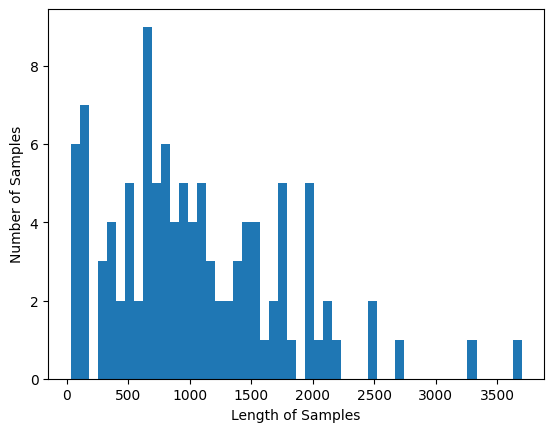

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# 희귀 단어를 사용하지 않고 토크나이저 재구성
tokenizer = Tokenizer(vocab_size, oov_token="<oov>")
tokenizer.fit_on_texts(X_train)

X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_train_encoded[:3]

# 길이가 1미만인 배열의 인덱스 - 텍스트가 없다!
drop_train = [index for index, sentence in enumerate(X_train_encoded) if len(sentence) < 1]

# feature가 제거 되었기 때문에 label도 제거
y_train = np.array(df['name'])
y_train = np.delete(y_train, drop_train, axis=0)

# 길이가 1 이상인 샘플만 남깁니다.
X_train_encoded = [sentence for sentence in X_train_encoded if len(sentence) >= 1]
print(X_train_encoded[:3])

print("리뷰의 최대 길이 : {}".format(max(len(l) for l in X_train_encoded)))
print("리뷰의 평균 길이 : {}".format(sum(map(len, X_train_encoded)) / len(X_train_encoded)))

# 시각화
plt.hist([len(s) for s in X_train_encoded], bins=50)
plt.xlabel("Length of Samples")
plt.ylabel("Number of Samples")
plt.show()


In [77]:
# 정규화

import re

def normalize(text):
    text = re.sub('ㅋ{2,}', ' 웃음 ', text)
    text = re.sub('ㄱ{2,}', ' 웃음 ', text)
    return text

df['normalized_review'] = df['tokenized_review'].apply(lambda x: [normalize(word) for word in x])


In [57]:
# N 그램
from sklearn.feature_extraction.text import CountVectorizer

df['joined_review'] = df['normalized_review'].apply(' '.join)

vectorizer = CountVectorizer(ngram_range=(1, 2))  # Unigrams and bigrams
X = vectorizer.fit_transform(df['joined_review'])

print(vectorizer.get_feature_names_out())




['00' '00 들어왔' '00 마감' ... '힙하 챙기고' '힙할' '힙할 있군요']


In [58]:
# 벡터화 첫번째 CountVectorizer (Bag of Words) Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['joined_review'])

print(vectorizer.get_feature_names_out())
print(X.toarray())



['00' '000' '000원' ... '힘없' '힙하' '힙할']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [59]:
# 벡터화 두번쨰 TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['joined_review'])

print(vectorizer.get_feature_names_out())
print(X.toarray())


['00' '000' '000원' ... '힘없' '힙하' '힙할']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [60]:
# 벡터화 세번째 Word2Vec Word2Vec
from gensim.models import Word2Vec

# Assuming `tokenized_reviews` is a list of tokenized reviews
model = Word2Vec(tokenized_reviews, size=100, window=5, min_count=1, workers=4)

# Get the vector for a word
word_vector = model.wv['coffee']



NameError: name 'tokenized_reviews' is not defined

In [81]:
# 벡터화 네번째 BERT 
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

text = "Here is some text to encode"
encoded_input = tokenizer(text, return_tensors='pt')

output = model(**encoded_input)

last_layer_hidden_states = output[0]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [93]:
reviews = df['review'].values  
labels = df['name'].values  


In [94]:
# BERT 벡터 추출
X = []
for review in reviews:
    encoded_input = tokenizer(review, return_tensors='pt', truncation=True, max_length=512)
    output = model(**encoded_input)
    last_hidden_state = output[0]  
    cls_embedding = last_hidden_state[0][0].detach().numpy() 
    X.append(cls_embedding)


In [97]:
# 학습/테스트 데이터 분리
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)



In [98]:
# 모델 학습 및 평가 => 로지스틱 회귀 모델
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

predictions = model_lr.predict(X_test)

print("Accuracy: ", accuracy_score(y_test.tolist(), predictions))


Accuracy:  0.09090909090909091


c:\Users\figure.2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [99]:
# 모델 학습 및 평가 => SVM 모델
from sklearn import svm

model_svm = svm.SVC()
model_svm.fit(X_train, y_train)

predictions_svm = model_svm.predict(X_test)

print("SVM Accuracy: ", accuracy_score(y_test.tolist(), predictions_svm))


SVM Accuracy:  0.0


In [100]:
# 모델 학습 및 평가 => Random Forest
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

predictions_rf = model_rf.predict(X_test)

print("Random Forest Accuracy: ", accuracy_score(y_test.tolist(), predictions_rf))


Random Forest Accuracy:  0.13636363636363635


In [103]:
# 오류 분석
from sklearn.model_selection import train_test_split

# 원본 리뷰와 벡터화된 X, 라벨을 함께 분할
X_train, X_test, reviews_train, reviews_test, y_train, y_test = train_test_split(X, reviews, labels,test_size=0.2)



In [105]:
import numpy as np

wrong_predictions = y_test != predictions

#  잘못 예측 되었다고 예상되는 리뷰와 실제 리뷰
for review, true_label in zip(np.array(reviews_test)[wrong_predictions], y_test[wrong_predictions]):
    print(f"Review: {review}")
    print(f"True label: {true_label}\n")


Review: 비엔나 커피 맛있어요 유명한 스콘집이라고 왔어요 분위기도좋고 스콘도 맛있네요 특이한 스콘이 많아요 또 올께요 분위기가 예쁘고 친절해요 굳 맛있어요 음료가 너무 맛있어요 실내디자인 고급져요 휘낭시에랑 스콘 너무 예쁘고 선물하기에도 좋아요 매장도 너무 예쁘고 친절하셔서 또 방문하려고 위치가 좋고 종류가 많아서 좋아용 과총회관에 있는 커피숍 괜찮아요 점심시간이라 사람이 많아서 정신이 없긴했지만 직원분들 친절하고 스콘도 맛있었어요 긋 커피가 저렴한데 휘낭시에 지진짜 들렸다가 그냥 왔는데 진짜맛집을 스콘 종류도 다양하고 맛있습니다 커피도 산미와 고소한 맛이 조화가 잘 맞아서 스콘과 맛있게 먹었어요 일부러 온 보람이 있습니다 비엔나 더치 커피가 정말 맛있고 디저트도 맛있어요 매장 넓고 쾌적합니다 한국과학기술회관 왔을때 테이크아웃 하기 좋아요 테이크아웃 할인 좋습니다 스콘 맛있고 커피도 냠냠 맛있을걸요 제가 한번 먹어보겠습니다 가격도 적당하고 좋은거 같습니다 커피 맛있어요 맛있는 디저트 먹고싶어서 방문했어요 스콘 휘낭시에 다 넘 맛있네요 비엔나 커피는 단짠씁쓸함이 조화를 이루네요ㅎ 자주올것 분위기도 좋고 디저트 종류도 맛있어요 스콘 종류도 많고 먹음직스럽습니다ㅎㅎ 매장도 넓고 인테리어도 디저트가 다양해요 또 재방문할 의향 추석 선물로 레뽀드라라 스콘세트 네이버에서 예약하시면 현장에서 구매하는 것보다 비싸다고 주인분께서 알려주셔서 다음에는 네이버 가 아닌 현장에서 구입하려구요 현장에선 겟 네이버 리뷰까지 하시면 아메리카노 공짜 여유있게 방문하셔서 아메리카노까지 겟하세요 분위기 아늑하고 좋아요 무화과스콘 진짜 좋아하는데 밀크티랑 같이 먹으니 더 맛있네요 굿 조용히 이야기하기 커피도 살짝 데워주신 미니 스콘이 풍미 있고 맛있어요 말차맛은 입안에서 향긋했고 초코맛은 이미 비주얼부터가 매력이 있었어요 오늘은 아메리카노 마셨는데 다음번엔 시그니처 밀크티 먹어보고 싶네요 아메리카노 가성비 좋아요 커피맛나요 매일 옵니다 ㅎㅎ 맛 변하지말아주세요 아메리카노 우유는 오트로 변

뭐지,,,,? 0 아님 1이여야 하느것 같은데 숫자가 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ

In [106]:
# 'predictions'는 모델이 테스트 데이터셋에 대해 예측한 라벨들입니다.
positive_reviews = sum(predictions == 1)
negative_reviews = sum(predictions == 0)

print(f"Positive reviews: {positive_reviews}")
print(f"Negative reviews: {negative_reviews}")


Positive reviews: 0
Negative reviews: 0


In [63]:
cls_token_output = last_layer_hidden_states[:, 0, :]


In [64]:

first_token_output = last_layer_hidden_states[:, 1, :]


In [86]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


reviews = df['review'].values
labels = df['name'].values 

X = []
for review in reviews:
    encoded_input = tokenizer(review, return_tensors='pt', truncation=True, max_length=512)
    output = model(**encoded_input)
    last_hidden_state = output[0]  
    cls_embedding = last_hidden_state[0][0].detach().numpy() 
    X.append(cls_embedding)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)   

predictions = model_lr.predict(X_test)
print("Accuracy: ", accuracy_score(y_test.tolist(), predictions))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy:  0.13636363636363635


c:\Users\figure.2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [90]:
print(df['name'].value_counts())

name
94    3
15    3
53    2
57    2
98    2
     ..
1     1
36    1
28    1
29    1
8     1
Name: count, Length: 99, dtype: int64


텍스트 전처리: 텍스트 데이터는 종종 불필요한 문자나 구두점, 불용어 등을 포함하고 있을 수 있습니다. 이러한 요소들은 모델의 성능에 부정적인 영향을 줄 수 있으므로 제거하는 것이 좋습니다. 한글 텍스트의 경우 KoNLPy와 같은 패키지를 사용하여 형태소 분석 및 불용어 제거를 수행할 수 있습니다.  

벡터화: 모델이 텍스트 데이터를 처리할 수 있도록, 각 리뷰를 숫자 벡터로 변환해야 합니다. 이 과정을 '벡터화'라고 합니다. TF-IDF, Word2Vec, BERT 등 다양한 방법이 존재합니다.  

모델 학습: 벡터화된 리뷰 데이터와 해당 감성 라벨(긍정/부정)을 사용하여 모델을 학습시킵니다. 여기서는 주로 분류 알고리즘(예: 로지스틱 회귀, SVM 등)이 사용됩니다.  

모델 평가 및 최적화: 검증 데이터셋으로 모델의 성능을 평가하고 필요에 따라 하이퍼파라미터 조정 등으로 모델을 최적화합니다.  

예측: 최종적으로 학습된 모델을 사용하여 새로운 리뷰의 감성 분류 예측에 활용합니